 # 1. Setup & Utility Functions

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, classification_report)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, 
                              AdaBoostClassifier, BaggingClassifier)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")


 # 2. Data Loading & Feature Engineering

In [5]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df = df.drop(columns=['id'], errors='ignore')
    
    # 1. Handling Missing Values
    initial_len = len(df)
    df = df.dropna()
    print(f"🗑️ Dropped {initial_len - len(df)} rows with missing values.")

    # 2. Feature Engineering
    # Service score aggregation
    service_cols = [
        'Inflight wifi service', 'Departure/Arrival time convenient', 
        'Ease of Online booking', 'Gate location', 'Food and drink', 
        'Online boarding', 'Seat comfort', 'Inflight entertainment', 
        'On-board service', 'Leg room service', 'Baggage handling', 
        'Checkin service', 'Inflight service', 'Cleanliness'
    ]
    df['Total Service Score'] = df[service_cols].sum(axis=1)

    # Net delay
    df['Total length of delayed flights'] = (
        df['Arrival Delay in Minutes'] - df['Departure Delay in Minutes']
    )

    # Age Group (Quantile Cut)
    df['Age Group'] = pd.qcut(df['Age'], q=4, labels=['Teen', 'Adult', 'Middle', 'Senior'])

    # Flight Distance Category
    distance_bins = [0, 500, 2000, 10000]
    df['Flight Distance Category'] = pd.cut(
        df['Flight Distance'], bins=distance_bins, labels=['Short', 'Medium', 'Long'], include_lowest=True
    )
    
    return df

# Load Data
df = load_and_preprocess_data("airline.csv")
print(f"✅ Data Loaded. Shape: {df.shape}")


🗑️ Dropped 393 rows with missing values.
✅ Data Loaded. Shape: (129487, 27)


 # 3. Feature Categorization & Encoding

In [6]:
target_col = 'satisfaction'

# Encode Target
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print(f"🎯 Target '{target_col}' encoded. Classes: {le.classes_}")

# Define Feature Groups
# 1. Ordinal Features (Manually specified based on domain knowledge ensures accuracy)
ordinal_cols = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
    'Flight Distance Category' # Engineered
]

# 2. Categorical Features (Nominal) -> Need One-Hot Encoding
nominal_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Age Group']

# 3. Continuous Features -> Need Scaling
# Logic: All numeric columns that are NOT target, NOT ordinal, and NOT binary
numeric_all = df.select_dtypes(include=['number']).columns.tolist()
exclude_cols = [target_col] + ordinal_cols
continuous_cols = [c for c in numeric_all if c not in exclude_cols and df[c].nunique() > 2]

# Map Ordinal text to numbers if necessary (e.g. Flight Distance Category)
dist_map = {'Short': 0, 'Medium': 1, 'Long': 2}
if df['Flight Distance Category'].dtype == 'category':
     df['Flight Distance Category'] = df['Flight Distance Category'].map(dist_map).astype(int)

# One-Hot Encoding for Nominal Features
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

print("\n📊 Feature Groups Summary:")
print(f"   Continuous ({len(continuous_cols)}): {continuous_cols}")
print(f"   Ordinal ({len(ordinal_cols)}): {ordinal_cols}")
print(f"   Nominal (One-Hot Encoded): {nominal_cols}")
print(f"   Final Columns: {df_encoded.shape[1]}")


🎯 Target 'satisfaction' encoded. Classes: ['neutral or dissatisfied' 'satisfied']

📊 Feature Groups Summary:
   Continuous (6): ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Total Service Score', 'Total length of delayed flights']
   Ordinal (15): ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Flight Distance Category']
   Nominal (One-Hot Encoded): ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Age Group']
   Final Columns: 30


 # 4. Splitting & Scaling strategy

In [7]:
# Split Data
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling Strategy
# We create TWO versions of datasets:
# 1. Non-Scaled: For Tree-based models (Random Forest, XGBoost, etc.) - Preserves original interpretability
# 2. Scaled: For Distance/Gradient models (LR, KNN, SVM, MLP) - Mandatory for convergence

scaler = StandardScaler()

# Only scale CONTINUOUS columns. Leave Binary (0/1) and Ordinal (0-5) alone!
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

print("✅ Data Preparation Complete.")
print(f"   Train Shape: {X_train.shape}")
print(f"   Test Shape:  {X_test.shape}")

✅ Data Preparation Complete.
   Train Shape: (103589, 29)
   Test Shape:  (25898, 29)


 # 5. The Evaluation Engine

In [8]:
# Global list to store results across different rounds
# format: {'Round': 'R1', 'Model': '...', 'Accuracy': ..., ...}
experiment_log = []

def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test, round_name="Round 1", plot_roc=False):
    """
    Unified training and evaluation function.
    Returns a dictionary of metrics.
    """
    start_time = time.time()
    
    # 1. Train
    model.fit(X_train, y_train)
    
    # 2. Predict
    y_pred = model.predict(X_test)
    
    # Handle models that might not have predict_proba (e.g., some SVM configs), though ours do.
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = [0] * len(y_test) # Fallback
        
    run_time = time.time() - start_time
    
    # 3. Calculate Metrics
    results = {
        'Round': round_name,
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='binary'),
        'Recall': recall_score(y_test, y_pred, average='binary'),
        'F1 Score': f1_score(y_test, y_pred, average='binary'),
        'AUC': roc_auc_score(y_test, y_proba) if hasattr(model, "predict_proba") else 0.0,
        'Time (s)': run_time
    }
    
    # 4. Optional Individual ROC Plot
    if plot_roc and hasattr(model, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results["AUC"]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    return results, y_proba

print("✅ Evaluation Engine Ready.")


✅ Evaluation Engine Ready.


 # 6. Round 1: Baseline Models

In [9]:
# Define Models Dictionary (Initialize with default parameters)
# Using random_state=42 for reproducibility
models = {
    # Scale-Dependent Models
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'GaussianNB': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=300),
    
    # Scale-Invariant Models
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Bagging': BaggingClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# List of models that require Scaled Data
scaled_models_list = ['Logistic Regression', 'KNN', 'GaussianNB', 'MLP']

# Dictionary to store probabilities for the combined ROC plot later
r1_probabilities = {}

print("🚀 Starting Round 1 Training...")
print("-" * 60)

for name, model in models.items():
    # Intelligent Data Selection
    if name in scaled_models_list:
        X_tr, X_te = X_train_scaled, X_test_scaled
        data_type = "Scaled"
    else:
        X_tr, X_te = X_train, X_test
        data_type = "Original"
        
    print(f"🔄 Training {name:20} | Data: {data_type}...", end=" ")
    
    # Run Engine (plot_roc=False to keep notebook clean, we will plot combined)
    res, proba = train_and_evaluate(model, name, X_tr, y_train, X_te, y_test, round_name="R1", plot_roc=False)
    
    # Log Results
    experiment_log.append(res)
    r1_probabilities[name] = proba
    
    print(f"Done. (AUC: {res['AUC']:.4f}, F1: {res['F1 Score']:.4f})")


🚀 Starting Round 1 Training...
------------------------------------------------------------
🔄 Training Logistic Regression  | Data: Scaled... Done. (AUC: 0.9247, F1: 0.8506)
🔄 Training KNN                  | Data: Scaled... Done. (AUC: 0.9685, F1: 0.9101)
🔄 Training GaussianNB           | Data: Scaled... Done. (AUC: 0.9124, F1: 0.8244)
🔄 Training MLP                  | Data: Scaled... Done. (AUC: 0.9936, F1: 0.9502)
🔄 Training Decision Tree        | Data: Original... Done. (AUC: 0.9432, F1: 0.9358)
🔄 Training Random Forest        | Data: Original... Done. (AUC: 0.9929, F1: 0.9511)
🔄 Training Extra Trees          | Data: Original... Done. (AUC: 0.9925, F1: 0.9498)
🔄 Training AdaBoost             | Data: Original... Done. (AUC: 0.9744, F1: 0.9097)
🔄 Training Bagging              | Data: Original... Done. (AUC: 0.9880, F1: 0.9508)
🔄 Training XGBoost              | Data: Original... Done. (AUC: 0.9944, F1: 0.9534)
🔄 Training LightGBM             | Data: Original... Done. (AUC: 0.9943, F1: 

 ### Round 1 Analysis & Visualization


📊 Round 1 Model Comparison (Sorted by AUC):


,Round,Model,Accuracy,Precision,Recall,F1 Score,AUC,Time (s)
0,R1,XGBoost,0.960151,0.968466,0.938861,0.953434,0.994384,0.804534
1,R1,LightGBM,0.960846,0.973721,0.935128,0.954034,0.994345,0.868452
2,R1,MLP,0.957719,0.973876,0.927575,0.950162,0.993620,213.954981
3,R1,Random Forest,0.958221,0.968494,0.934240,0.951058,0.992875,2.879507
4,R1,Extra Trees,0.957255,0.969201,0.931218,0.949830,0.992465,2.469140
5,R1,Bagging,0.958028,0.969258,0.932996,0.950781,0.987973,9.370412
6,R1,AdaBoost,0.922040,0.915347,0.904203,0.909741,0.974392,16.965635
7,R1,KNN,0.923662,0.932407,0.888741,0.910051,0.968527,9.801779
8,R1,Decision Tree,0.944281,0.936466,0.935217,0.935841,0.943232,1.550485
9,R1,Logistic Regression,0.873118,0.870662,0.831512,0.850636,0.924744,0.726961


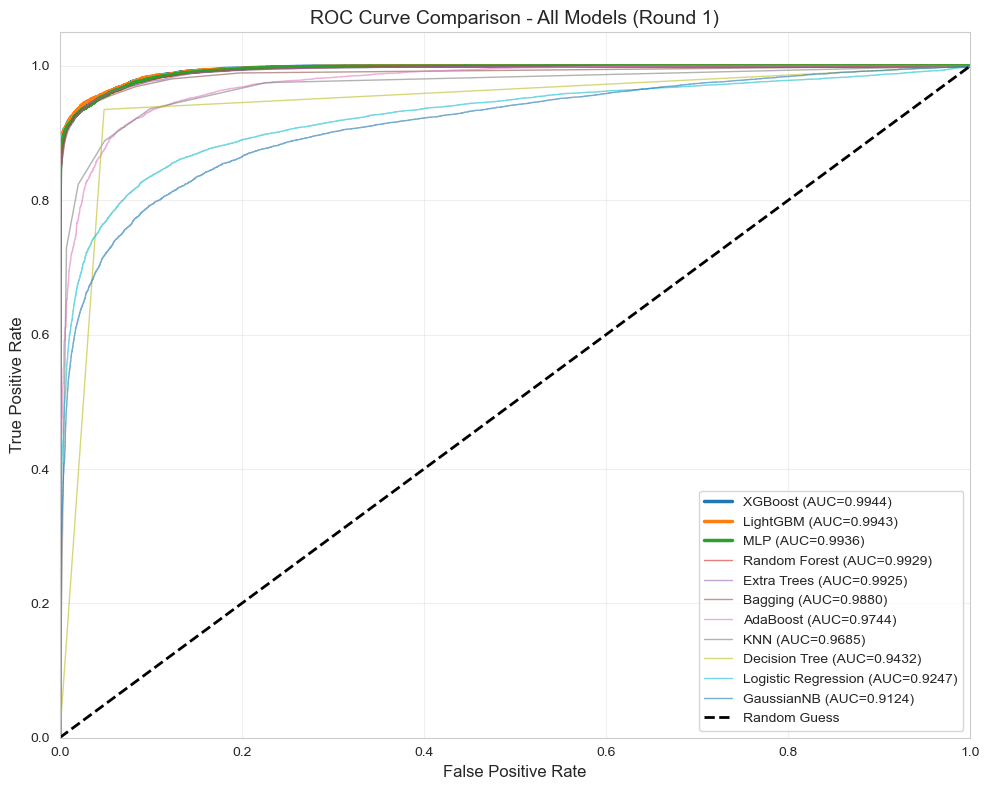

In [10]:
# 1. Create DataFrame
df_r1 = pd.DataFrame([row for row in experiment_log if row['Round'] == 'R1'])
df_r1 = df_r1.sort_values(by='AUC', ascending=False).reset_index(drop=True)

# 2. Display Table
print("\n📊 Round 1 Model Comparison (Sorted by AUC):")
display(df_r1.style.background_gradient(cmap='Blues', subset=['Accuracy', 'F1 Score', 'AUC']))

# 3. Plot Combined ROC Curve (Professional Publication Style)
plt.figure(figsize=(10, 8))

for name in df_r1['Model']:
    # Get proba
    y_prob = r1_probabilities[name]
    auc_score = df_r1.loc[df_r1['Model'] == name, 'AUC'].values[0]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Highlight top 3 models with thicker lines
    lw = 2.5 if name in df_r1.head(3)['Model'].values else 1
    alpha = 1.0 if name in df_r1.head(3)['Model'].values else 0.6
    
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.4f})', lw=lw, alpha=alpha)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - All Models (Round 1)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_round1_baseline.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Save results
df_r1.to_csv("round1_baseline_results.csv", index=False)


 # 7. Round 2: Hyperparameter Tuning

In [11]:
# 字典用于存储最佳参数
best_params_storage = {}

def tune_model(base_model, param_grid, name, X_train, y_train, X_test, y_test, search_type='grid'):
    """
    Unified Tuning Function.
    """
    print(f"🔧 Tuning {name}...", end=" ")
    start_tune = time.time()
    
    # 1. Choose Search Strategy
    if search_type == 'grid':
        search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='f1',
            cv=3,
            n_jobs=-1,
            verbose=0
        )
    else:
        search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grid,
            n_iter=5,
            scoring='f1',
            cv=3,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
    # 2. Fit Search
    search.fit(X_train, y_train)
    tune_time = time.time() - start_tune
    
    # 3. Get Best Model & Params
    best_model = search.best_estimator_
    best_params = search.best_params_
    best_params_storage[name] = best_params
    
    print(f"Best Params Found (Time: {tune_time:.1f}s)")
    
    # 4. Evaluate on Test Set
    # ✅ 修改点：这里接收两个返回值 (res, proba)
    res, proba = train_and_evaluate(
        best_model, name, X_train, y_train, X_test, y_test, 
        round_name="R2 (Tuned)", plot_roc=False
    )
    
    res['Best Parameters'] = str(best_params)
    
    # ✅ 修改点：返回结果的同时，把概率也返回去
    return res, proba

 ### Configuration: Parameter Grids

In [12]:
# Define Optimized Hyperparameter Grids (Speed-Focused)
param_grids = {
    # Linear Models
    'Logistic Regression': {
        'C': [0.1, 1, 10],  # Reduced options
        'solver': ['lbfgs'] # Liblinear is slower on large datasets
    },
    'KNN': {
        'n_neighbors': [5, 7],     # Removed 3 (too noisy)
        'weights': ['distance']    # Removed uniform (distance usually better)
    },
    'MLP': {
        # Removed (50, 50) which is very slow
        'hidden_layer_sizes': [(50,), (100,)], 
        'alpha': [0.0001, 0.01],
        'learning_rate_init': [0.01] # Fixed learning rate to save time
    },
    
    # Tree Models
    'Decision Tree': {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 10],
        'criterion': ['gini'] # Entropy is slower to calculate
    },
    'Random Forest': {
        'n_estimators': [100], # Removed 200 to save time
        'max_depth': [10, 20],
        'min_samples_leaf': [1, 4],
        'bootstrap': [True]
    },
    'Extra Trees': {
        'n_estimators': [100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 10]
    },
    'XGBoost': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [6, 10],
        'subsample': [0.8]
    },
    'LightGBM': {
        'n_estimators': [100],      # Removed 200
        'learning_rate': [0.1],     # Fixed rate
        'num_leaves': [31],         # Removed 63 (complexity killer)
        'max_depth': [10, 20]       # REMOVED -1 (Infinite depth is the time killer!)
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 1.0]
    },
    'Bagging': {
        'n_estimators': [50],
        'max_samples': [0.8, 1.0]
    },
    'GaussianNB': {
         'var_smoothing': [1e-9, 1e-8]
    }
}

# Map which search strategy to use
# Changed MLP to 'random' to avoid running all combos if grid expands
search_strategies = {
    'Logistic Regression': 'grid',
    'KNN': 'grid', 
    'GaussianNB': 'grid',
    'MLP': 'random',       # CHANGED: grid -> random
    'Decision Tree': 'grid',
    'Random Forest': 'random',
    'Extra Trees': 'random',
    'XGBoost': 'random',
    'LightGBM': 'random',
    'AdaBoost': 'random',
    'Bagging': 'random'
}

 ### Run Tuning Loop

In [13]:
r2_probabilities = {}

print("🚀 Starting Round 2: Hyperparameter Tuning...")
print("-" * 60)

for name, model in models.items():
    # 1. Get correct data
    if name in scaled_models_list:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
        
    # 2. Get params
    if name not in param_grids:
        continue 
        
    grid = param_grids[name]
    strategy = search_strategies.get(name, 'grid')
    
    # 3. Run Tune
    res, proba = tune_model(model, grid, name, X_tr, y_train, X_te, y_test, search_type=strategy)
    
    # 4. Log
    experiment_log.append(res)
    
    r2_probabilities[name] = proba

print("✅ Round 2 Completed.")

🚀 Starting Round 2: Hyperparameter Tuning...
------------------------------------------------------------
🔧 Tuning Logistic Regression... Best Params Found (Time: 3.0s)
🔧 Tuning KNN... Best Params Found (Time: 27.4s)
🔧 Tuning GaussianNB... Best Params Found (Time: 3.9s)
🔧 Tuning MLP... Best Params Found (Time: 111.6s)
🔧 Tuning Decision Tree... Best Params Found (Time: 4.0s)
🔧 Tuning Random Forest... Best Params Found (Time: 21.3s)
🔧 Tuning Extra Trees... Best Params Found (Time: 18.4s)
🔧 Tuning AdaBoost... Best Params Found (Time: 32.3s)
🔧 Tuning Bagging... Best Params Found (Time: 27.8s)
🔧 Tuning XGBoost... Best Params Found (Time: 6.4s)
🔧 Tuning LightGBM... Best Params Found (Time: 6.6s)
✅ Round 2 Completed.


 ### Round 2 Analysis


📊 Tuned Models Performance:


,Model,Accuracy,F1 Score,AUC,Best Parameters
0,XGBoost,0.961773,0.955268,0.994737,"{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}"
1,LightGBM,0.960846,0.954034,0.994345,"{'num_leaves': 31, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1}"
2,MLP,0.958221,0.951305,0.993510,"{'learning_rate_init': 0.01, 'hidden_layer_sizes': (100,), 'alpha': 0.0001}"
3,Random Forest,0.957873,0.950689,0.992745,"{'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}"
4,Bagging,0.959842,0.952996,0.992289,"{'n_estimators': 50, 'max_samples': 1.0}"
5,Extra Trees,0.955054,0.947402,0.992266,"{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20}"
6,AdaBoost,0.922040,0.909741,0.974392,"{'n_estimators': 100, 'learning_rate': 1.0}"
7,KNN,0.924820,0.911092,0.973485,"{'n_neighbors': 7, 'weights': 'distance'}"
8,Decision Tree,0.948915,0.940713,0.967721,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}"
9,Logistic Regression,0.873118,0.850636,0.924744,"{'C': 1, 'solver': 'lbfgs'}"


📷 ROC Curve saved as 'roc_round2_tuned.png'


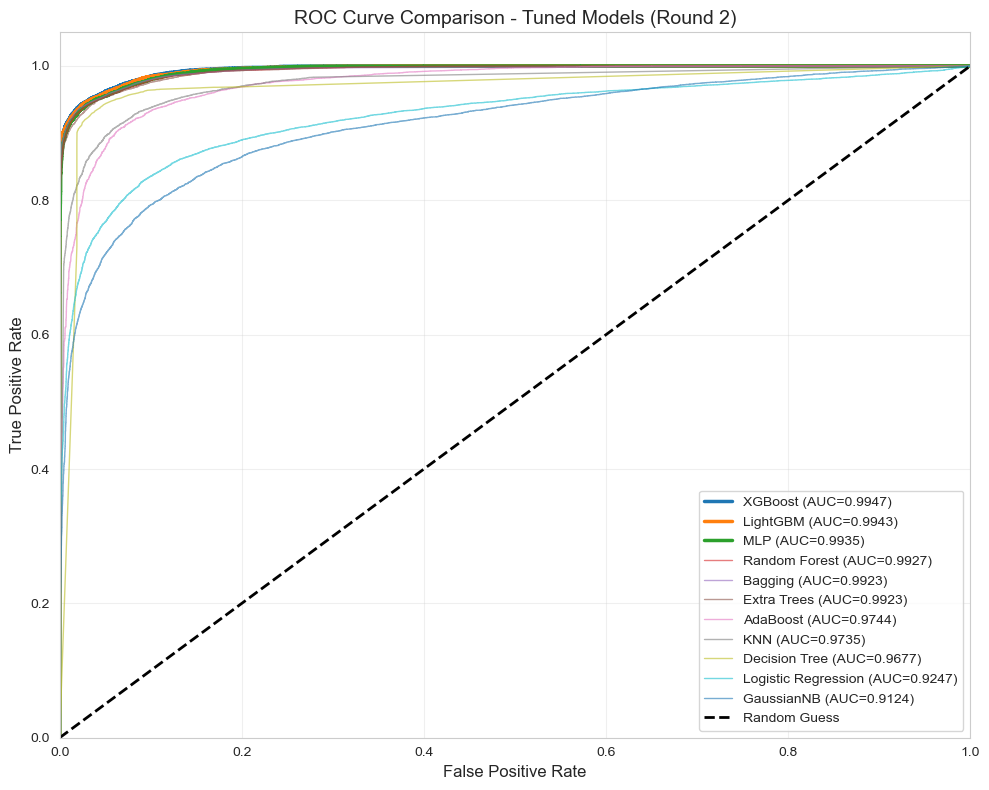

In [14]:
# Create DataFrame
df_r2 = pd.DataFrame([row for row in experiment_log if row['Round'] == 'R2 (Tuned)'])
df_r2 = df_r2.sort_values(by='AUC', ascending=False).reset_index(drop=True)

print("\n📊 Tuned Models Performance:")
display(df_r2[['Model', 'Accuracy', 'F1 Score', 'AUC', 'Best Parameters']].style.background_gradient(cmap='Greens', subset=['AUC']))

# Save CSV
df_r2.to_csv("round2_tuned_results.csv", index=False)

# ✅ 新增：画 ROC 图并保存
plt.figure(figsize=(10, 8))

for name in df_r2['Model']:
    # 从字典里取概率
    if name in r2_probabilities:
        y_prob = r2_probabilities[name]
        auc_score = df_r2.loc[df_r2['Model'] == name, 'AUC'].values[0]
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        
        # Highlight top 3 models
        lw = 2.5 if name in df_r2.head(3)['Model'].values else 1
        alpha = 1.0 if name in df_r2.head(3)['Model'].values else 0.6
        
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.4f})', lw=lw, alpha=alpha)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Tuned Models (Round 2)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# ✅ 保存图片到本地
plt.savefig("roc_round2_tuned.png", dpi=300, bbox_inches='tight')
print("📷 ROC Curve saved as 'roc_round2_tuned.png'")

plt.show()

 # 8. Round 3: Feature Selection

🚀 Starting Round 3: Feature Selection...
✅ Selected Top 10 Features:
['Online boarding', 'Inflight wifi service', 'Type of Travel_Personal Travel', 'Class_Eco', 'Total Service Score', 'Inflight entertainment', 'Ease of Online booking', 'Seat comfort', 'Customer Type_disloyal Customer', 'Flight Distance']


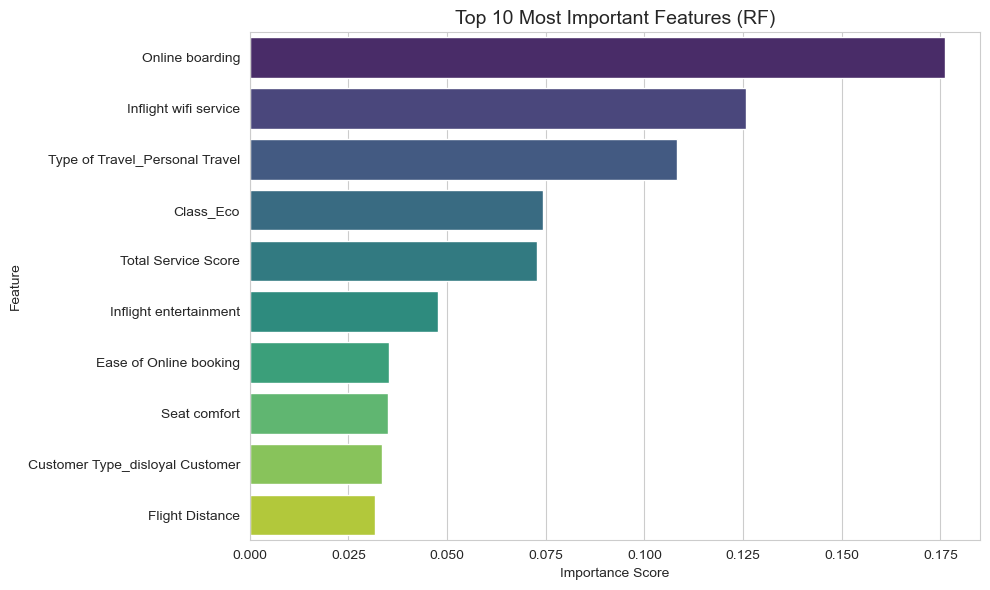

   Subset Shape: (103589, 10)
------------------------------------------------------------
🔄 R3: Training Logistic Regression  | Data: Scaled (Sub)... Done. (AUC: 0.9131)
🔄 R3: Training KNN                  | Data: Scaled (Sub)... Done. (AUC: 0.9737)
🔄 R3: Training GaussianNB           | Data: Scaled (Sub)... Done. (AUC: 0.9183)
🔄 R3: Training MLP                  | Data: Scaled (Sub)... Done. (AUC: 0.9884)
🔄 R3: Training Decision Tree        | Data: Original (Sub)... Done. (AUC: 0.9209)
🔄 R3: Training Random Forest        | Data: Original (Sub)... Done. (AUC: 0.9846)
🔄 R3: Training Extra Trees          | Data: Original (Sub)... Done. (AUC: 0.9776)
🔄 R3: Training AdaBoost             | Data: Original (Sub)... Done. (AUC: 0.9653)
🔄 R3: Training Bagging              | Data: Original (Sub)... Done. (AUC: 0.9765)
🔄 R3: Training XGBoost              | Data: Original (Sub)... Done. (AUC: 0.9888)
🔄 R3: Training LightGBM             | Data: Original (Sub)... Done. (AUC: 0.9884)


In [15]:
print("🚀 Starting Round 3: Feature Selection...")

# 1. Get Feature Importances using Random Forest (from Baseline)
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
feature_names = X_train.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# 2. Select Top K Features
K = 10
top_k_features = feature_imp_df.head(K)['Feature'].tolist()

print(f"✅ Selected Top {K} Features:")
print(top_k_features)

# 3. Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10), palette='viridis')
plt.title(f'Top 10 Most Important Features (RF)', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

# 4. Create Subset Datasets
# Note: We need to create subsets for BOTH scaled and non-scaled data
X_train_sel = X_train[top_k_features]
X_test_sel = X_test[top_k_features]

X_train_sel_scaled = X_train_scaled[top_k_features]
X_test_sel_scaled = X_test_scaled[top_k_features]

print(f"   Subset Shape: {X_train_sel.shape}")
print("-" * 60)

# 5. Train Models on Selected Features (Using Default Params to isolate effect)
for name, model in models.items():
    # Intelligent Data Selection
    if name in scaled_models_list:
        X_tr, X_te = X_train_sel_scaled, X_test_sel_scaled
        data_type = "Scaled (Sub)"
    else:
        X_tr, X_te = X_train_sel, X_test_sel
        data_type = "Original (Sub)"
        
    print(f"🔄 R3: Training {name:20} | Data: {data_type}...", end=" ")
    
    # We use a fresh clone of the model to reset parameters/weights
    from sklearn.base import clone
    model_clone = clone(model)
    
    res, _ = train_and_evaluate(
        model_clone, name, X_tr, y_train, X_te, y_test, 
        round_name=f"R3 (Top {K} Feats)", plot_roc=False
    )
    
    experiment_log.append(res)
    print(f"Done. (AUC: {res['AUC']:.4f})")


 ### Round 3 Analysis

In [16]:
# 1. Filter results for Round 3
df_r3 = pd.DataFrame([row for row in experiment_log if "R3" in row['Round']])
df_r3 = df_r3.sort_values(by='AUC', ascending=False).reset_index(drop=True)

# 2. Add a column to compare with Round 1 (Baseline)
# We calculate the difference to see if Feature Selection helped or hurt
baseline_aucs = {row['Model']: row['AUC'] for row in experiment_log if row['Round'] == 'R1'}
df_r3['Baseline AUC'] = df_r3['Model'].map(baseline_aucs)
df_r3['AUC Change'] = df_r3['AUC'] - df_r3['Baseline AUC']

print(f"\n📊 Round 3: Performance on Top {K} Features (Sorted by AUC):")
display(df_r3[['Model', 'Accuracy', 'F1 Score', 'AUC', 'AUC Change', 'Time (s)']]
        .style.background_gradient(cmap='RdYlGn', subset=['AUC Change'])) 
        # Red = Drop, Green = Improvement

# 3. Save
df_r3.to_csv("round3_feature_selection_results.csv", index=False)



📊 Round 3: Performance on Top 10 Features (Sorted by AUC):


,Model,Accuracy,F1 Score,AUC,AUC Change,Time (s)
0,XGBoost,0.944359,0.934882,0.988766,-0.005618,0.342979
1,LightGBM,0.943586,0.933852,0.988427,-0.005918,0.526057
2,MLP,0.943277,0.933641,0.988392,-0.005228,110.821986
3,Random Forest,0.936675,0.926173,0.984585,-0.008290,2.041365
4,Extra Trees,0.932427,0.921637,0.977614,-0.014851,1.480898
5,Bagging,0.934049,0.922771,0.976537,-0.011436,3.394378
6,KNN,0.935285,0.924273,0.973680,0.005153,6.808774
7,AdaBoost,0.904510,0.889058,0.965264,-0.009127,7.803481
8,Decision Tree,0.922156,0.910192,0.920866,-0.022365,0.494178
9,GaussianNB,0.857557,0.834537,0.918347,0.005944,0.070325


 # 9. Round 4: PCA (Dimensionality Reduction)


🚀 Starting Round 4: PCA Analysis...
✅ PCA Reduced dimensions: 29 --> 17


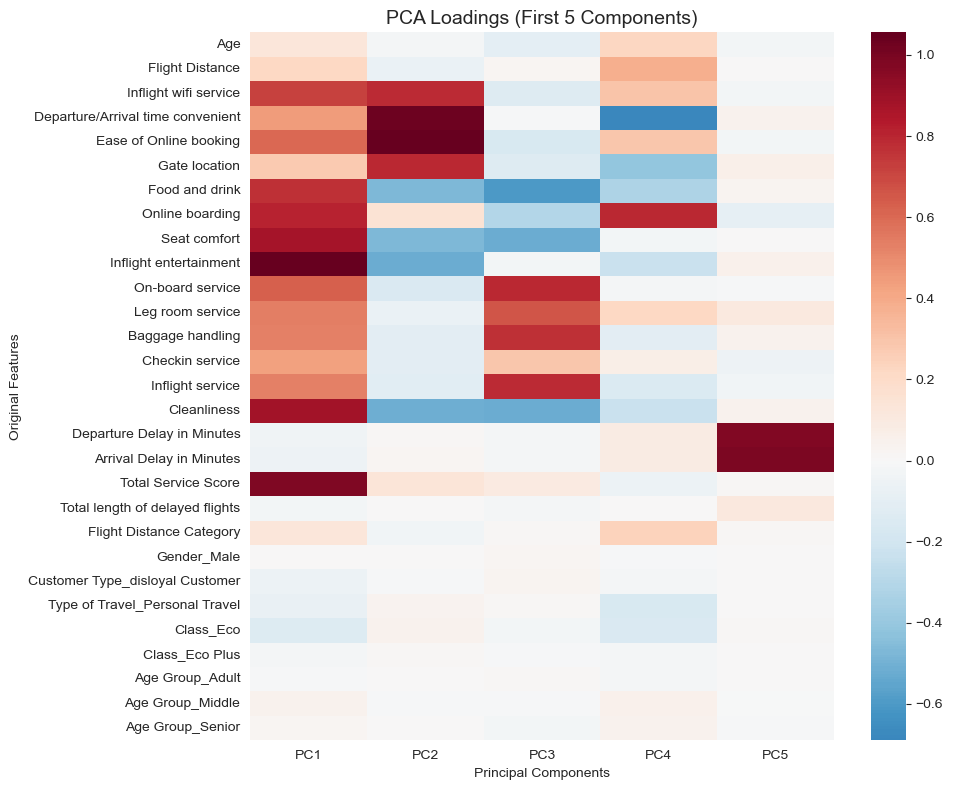

------------------------------------------------------------
🔄 R4: Training Logistic Regression  | Data: PCA... Done. (AUC: 0.8895)
🔄 R4: Training KNN                  | Data: PCA... Done. (AUC: 0.9641)
🔄 R4: Training GaussianNB           | Data: PCA... Done. (AUC: 0.8793)
🔄 R4: Training MLP                  | Data: PCA... Done. (AUC: 0.9888)
🔄 R4: Training Decision Tree        | Data: PCA... Done. (AUC: 0.8644)
🔄 R4: Training Random Forest        | Data: PCA... Done. (AUC: 0.9746)
🔄 R4: Training Extra Trees          | Data: PCA... Done. (AUC: 0.9779)
🔄 R4: Training AdaBoost             | Data: PCA... Done. (AUC: 0.8998)
🔄 R4: Training Bagging              | Data: PCA... Done. (AUC: 0.9636)
🔄 R4: Training XGBoost              | Data: PCA... Done. (AUC: 0.9795)
🔄 R4: Training LightGBM             | Data: PCA... Done. (AUC: 0.9711)


In [17]:
from sklearn.decomposition import PCA

print("\n🚀 Starting Round 4: PCA Analysis...")

# 1. Apply PCA
# PCA MUST use scaled data, even for tree models in this context
pca = PCA(n_components=0.95) # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

n_components = X_train_pca.shape[1]
print(f"✅ PCA Reduced dimensions: {X_train.shape[1]} --> {n_components}")

# 2. PCA Interpretation (Loadings Heatmap) - Great for Report!
# We look at the first few components
n_comp_plot = min(5, n_components) 
loadings = pca.components_[:n_comp_plot].T * np.sqrt(pca.explained_variance_[:n_comp_plot])
loadings_df = pd.DataFrame(
    loadings, 
    columns=[f'PC{i+1}' for i in range(n_comp_plot)], 
    index=X_train.columns
)

plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, cmap='RdBu_r', center=0, annot=False) # Annot=False to keep it clean
plt.title(f'PCA Loadings (First {n_comp_plot} Components)', fontsize=14)
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.tight_layout()
plt.show()

print("-" * 60)

# 3. Train Models on PCA Features
# Note: All models now use X_train_pca (which is derived from scaled data)
for name, model in models.items():
    
    print(f"🔄 R4: Training {name:20} | Data: PCA...", end=" ")
    
    model_clone = clone(model)
    
    res, _ = train_and_evaluate(
        model_clone, name, X_train_pca, y_train, X_test_pca, y_test, 
        round_name="R4 (PCA)", plot_roc=False
    )
    
    experiment_log.append(res)
    print(f"Done. (AUC: {res['AUC']:.4f})")


 ### Round 4 Analysis

In [18]:
# 1. Filter results for Round 4
df_r4 = pd.DataFrame([row for row in experiment_log if "R4" in row['Round']])
df_r4 = df_r4.sort_values(by='AUC', ascending=False).reset_index(drop=True)

# 2. Compare with Baseline
baseline_aucs = {row['Model']: row['AUC'] for row in experiment_log if row['Round'] == 'R1'}
df_r4['Baseline AUC'] = df_r4['Model'].map(baseline_aucs)
df_r4['AUC Change'] = df_r4['AUC'] - df_r4['Baseline AUC']

print(f"\n📊 Round 4: Performance with PCA ({n_components} Components):")
display(df_r4[['Model', 'Accuracy', 'F1 Score', 'AUC', 'AUC Change', 'Time (s)']]
        .style.background_gradient(cmap='RdYlGn', subset=['AUC Change']))

# 3. Save
df_r4.to_csv("round4_pca_results.csv", index=False)



📊 Round 4: Performance with PCA (17 Components):


,Model,Accuracy,F1 Score,AUC,AUC Change,Time (s)
0,MLP,0.942737,0.934010,0.988761,-0.004859,151.519567
1,XGBoost,0.924512,0.911846,0.979530,-0.014854,0.619537
2,Extra Trees,0.920303,0.904981,0.977873,-0.014592,2.816900
3,Random Forest,0.914858,0.899485,0.974635,-0.018240,13.306990
4,LightGBM,0.909568,0.893468,0.971061,-0.023284,0.759669
5,KNN,0.915013,0.899686,0.964114,-0.004412,7.025573
6,Bagging,0.904549,0.886376,0.963580,-0.024393,8.275101
7,AdaBoost,0.836706,0.805483,0.899818,-0.074573,60.199872
8,Logistic Regression,0.831763,0.801585,0.889510,-0.035234,0.137579
9,GaussianNB,0.820758,0.788866,0.879270,-0.033133,0.095018


 # 10. Round 5: Tuned Models + Feature Selection

In [19]:
print("🚀 Starting Round 5: Best Params + Top Features...")

# Helper to reconstruct model with best params
def get_tuned_instance(model_name, default_model):
    # If we have tuned params, use them

    if model_name in best_params_storage:
        params = best_params_storage[model_name]
        try:
            return default_model.__class__(**params, random_state=42)
        # Create new instance of the same class with unpacked params
        except TypeError:
            return default_model.__class__(**params)
    else:
        # Fallback to default if no tuning was done
        from sklearn.base import clone
        return clone(default_model)

for name, model in models.items():
    # 1. Prepare Data (Same logic as Round 3)
    if name in scaled_models_list:
        X_tr, X_te = X_train_sel_scaled, X_test_sel_scaled # Top-K Scaled
    else:
        X_tr, X_te = X_train_sel, X_test_sel # Top-K Original
        
    # 2. Prepare Model (Use Best Params from Round 2)
    # Note: Some models like XGBoost might need specific handling for fixed params vs tuned params
    # Here we assume the class constructor accepts the params dict
    try:
        tuned_model = get_tuned_instance(name, model)
        
        # Special handling: some params might need to be re-set if they weren't in grid
        # e.g. n_jobs for ensemble models
        if hasattr(tuned_model, 'n_jobs'): tuned_model.n_jobs = -1
        if hasattr(tuned_model, 'verbose'): tuned_model.verbose = 0
            
    except Exception as e:
        print(f"⚠️ Could not apply params for {name}, utilizing default. Error: {e}")
        from sklearn.base import clone
        tuned_model = clone(model)

    print(f"🔄 R5: Training {name:20} | Params: Tuned | Data: Top {K} Feats...", end=" ")
    
    # 3. Train & Evaluate
    res, _ = train_and_evaluate(
        tuned_model, name, X_tr, y_train, X_te, y_test, 
        round_name="R5 (Tuned+Sel)", plot_roc=False
    )
    
    experiment_log.append(res)
    print(f"Done. (AUC: {res['AUC']:.4f})")


🚀 Starting Round 5: Best Params + Top Features...
🔄 R5: Training Logistic Regression  | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9131)
🔄 R5: Training KNN                  | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9763)
🔄 R5: Training GaussianNB           | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9183)
🔄 R5: Training MLP                  | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9882)
🔄 R5: Training Decision Tree        | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9683)
🔄 R5: Training Random Forest        | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9881)
🔄 R5: Training Extra Trees          | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9884)
🔄 R5: Training AdaBoost             | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9653)
🔄 R5: Training Bagging              | Params: Tuned | Data: Top 10 Feats... Done. (AUC: 0.9837)
🔄 R5: Training XGBoost              | Params: Tuned | Data: Top 10 Feats... Done. (AUC

 ### Round 5 Analysis

In [20]:
df_r5 = pd.DataFrame([row for row in experiment_log if "R5" in row['Round']])
df_r5 = df_r5.sort_values(by='AUC', ascending=False).reset_index(drop=True)

print(f"\n📊 Round 5 Results (Tuned + Top {K} Features):")
display(df_r5[['Model', 'Accuracy', 'F1 Score', 'AUC', 'Time (s)']]
        .style.background_gradient(cmap='Blues', subset=['AUC']))

df_r5.to_csv("round5_tuned_selected_results.csv", index=False)



📊 Round 5 Results (Tuned + Top 10 Features):


,Model,Accuracy,F1 Score,AUC,Time (s)
0,XGBoost,0.944436,0.934949,0.988939,0.636252
1,LightGBM,0.943586,0.933852,0.988427,0.455721
2,Extra Trees,0.943239,0.933724,0.988358,1.207088
3,MLP,0.943895,0.934197,0.988205,53.155462
4,Random Forest,0.942660,0.932887,0.988067,1.844289
5,Bagging,0.935748,0.924889,0.983673,7.325896
6,KNN,0.932157,0.920945,0.976261,3.359070
7,Decision Tree,0.934396,0.923209,0.968290,0.477715
8,AdaBoost,0.904510,0.889058,0.965264,7.729959
9,GaussianNB,0.857557,0.834537,0.918347,0.065417


 # 11. Round 6: Tuned Models + PCA

In [21]:
print("\n🚀 Starting Round 6: Best Params + PCA Features...")

for name, model in models.items():
    # 1. Prepare Data (PCA data is universal for this round)
    X_tr, X_te = X_train_pca, X_test_pca
    
    # 2. Prepare Model (Use Best Params from Round 2)
    try:
        tuned_model = get_tuned_instance(name, model)
        if hasattr(tuned_model, 'n_jobs'): tuned_model.n_jobs = -1
        if hasattr(tuned_model, 'verbose'): tuned_model.verbose = 0
    except:
        from sklearn.base import clone
        tuned_model = clone(model)
        
    print(f"🔄 R6: Training {name:20} | Params: Tuned | Data: PCA...", end=" ")
    
    # 3. Train & Evaluate
    res, _ = train_and_evaluate(
        tuned_model, name, X_tr, y_train, X_te, y_test, 
        round_name="R6 (Tuned+PCA)", plot_roc=False
    )
    
    experiment_log.append(res)
    print(f"Done. (AUC: {res['AUC']:.4f})")



🚀 Starting Round 6: Best Params + PCA Features...
🔄 R6: Training Logistic Regression  | Params: Tuned | Data: PCA... Done. (AUC: 0.8895)
🔄 R6: Training KNN                  | Params: Tuned | Data: PCA... Done. (AUC: 0.9695)
🔄 R6: Training GaussianNB           | Params: Tuned | Data: PCA... Done. (AUC: 0.8793)
🔄 R6: Training MLP                  | Params: Tuned | Data: PCA... Done. (AUC: 0.9869)
🔄 R6: Training Decision Tree        | Params: Tuned | Data: PCA... Done. (AUC: 0.8766)
🔄 R6: Training Random Forest        | Params: Tuned | Data: PCA... Done. (AUC: 0.9729)
🔄 R6: Training Extra Trees          | Params: Tuned | Data: PCA... Done. (AUC: 0.9708)
🔄 R6: Training AdaBoost             | Params: Tuned | Data: PCA... Done. (AUC: 0.8998)
🔄 R6: Training Bagging              | Params: Tuned | Data: PCA... Done. (AUC: 0.9715)
🔄 R6: Training XGBoost              | Params: Tuned | Data: PCA... Done. (AUC: 0.9812)
🔄 R6: Training LightGBM             | Params: Tuned | Data: PCA... Done. (AUC: 

 ### Round 6 Analysis

In [22]:
df_r6 = pd.DataFrame([row for row in experiment_log if "R6" in row['Round']])
df_r6 = df_r6.sort_values(by='AUC', ascending=False).reset_index(drop=True)

print(f"\n📊 Round 6 Results (Tuned + PCA):")
display(df_r6[['Model', 'Accuracy', 'F1 Score', 'AUC', 'Time (s)']]
        .style.background_gradient(cmap='Blues', subset=['AUC']))

df_r6.to_csv("round6_tuned_pca_results.csv", index=False)



📊 Round 6 Results (Tuned + PCA):


,Model,Accuracy,F1 Score,AUC,Time (s)
0,MLP,0.941385,0.931150,0.986887,66.356302
1,XGBoost,0.927099,0.914586,0.981198,2.204259
2,Random Forest,0.913275,0.897293,0.972934,11.305496
3,Bagging,0.913893,0.899031,0.971489,33.256869
4,LightGBM,0.909568,0.893468,0.971061,0.698867
5,Extra Trees,0.905321,0.885964,0.970830,1.937038
6,KNN,0.916287,0.901050,0.969516,7.292109
7,AdaBoost,0.836706,0.805483,0.899818,59.550890
8,Logistic Regression,0.831763,0.801585,0.889510,1.195146
9,GaussianNB,0.820758,0.788866,0.879270,0.084312


 # 12. Final Experiment Summary

🏆 Final Model Leaderboard (AUC Scores across all rounds):


Round,R1,R2 (Tuned),R3 (Top 10 Feats),R4 (PCA),R5 (Tuned+Sel),R6 (Tuned+PCA),Max AUC
Model,,,,,,,
XGBoost,0.994384,0.994737,0.988766,0.979530,0.988939,0.981198,0.994737
LightGBM,0.994345,0.994345,0.988427,0.971061,0.988427,0.971061,0.994345
MLP,0.993620,0.993510,0.988392,0.988761,0.988205,0.986887,0.993620
Random Forest,0.992875,0.992745,0.984585,0.974635,0.988067,0.972934,0.992875
Extra Trees,0.992465,0.992266,0.977614,0.977873,0.988358,0.970830,0.992465
Bagging,0.987973,0.992289,0.976537,0.963580,0.983673,0.971489,0.992289
KNN,0.968527,0.973485,0.973680,0.964114,0.976261,0.969516,0.976261
AdaBoost,0.974392,0.974392,0.965264,0.899818,0.965264,0.899818,0.974392
Decision Tree,0.943232,0.967721,0.920866,0.864381,0.968290,0.876616,0.968290


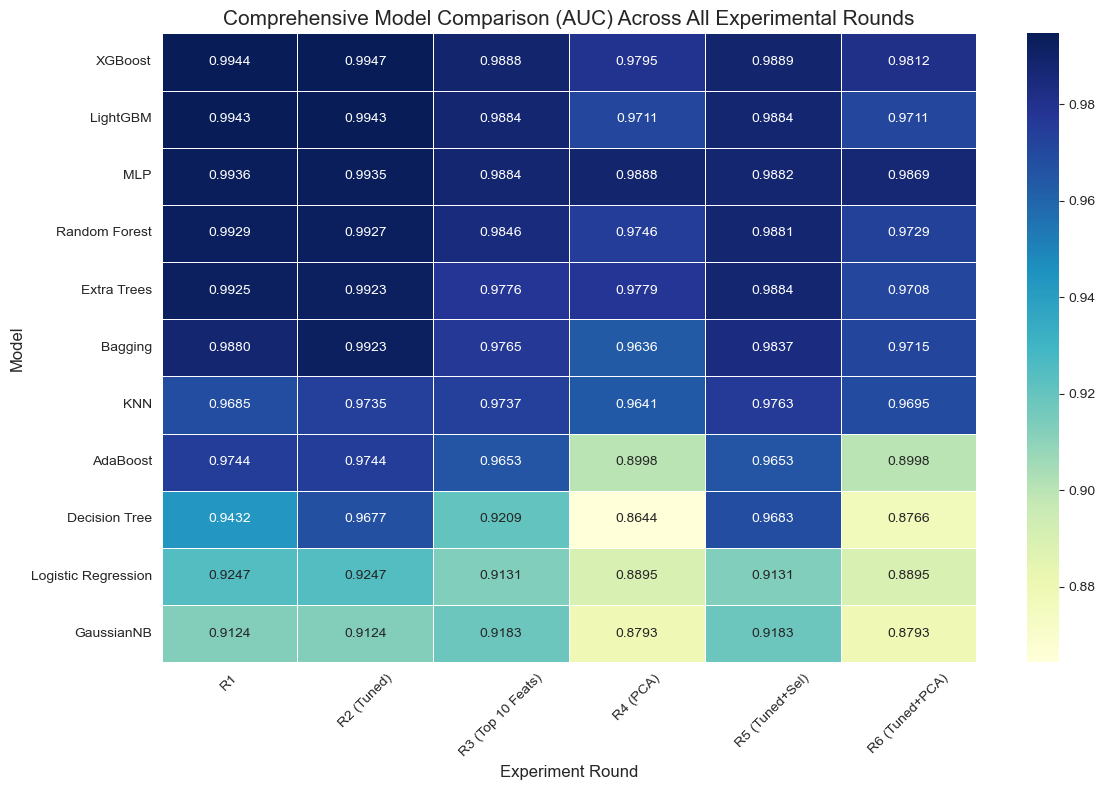

✅ All Experiments Completed Successfully!


In [23]:
# 1. Aggregate all results
final_df = pd.DataFrame(experiment_log)
final_df = final_df.drop_duplicates(subset=['Model', 'Round'], keep='last')

# 2. Pivot Table to compare Rounds easily
# Rows: Models, Columns: Rounds, Values: AUC
summary_pivot = final_df.pivot(index='Model', columns='Round', values='AUC')

# Reorder columns logically
round_order = ['R1', 'R2 (Tuned)', f'R3 (Top {K} Feats)', 'R4 (PCA)', 'R5 (Tuned+Sel)', 'R6 (Tuned+PCA)']
# Ensure columns exist (in case some rounds were skipped)
existing_cols = [c for c in round_order if c in summary_pivot.columns]
summary_pivot = summary_pivot[existing_cols]

# 3. Add a "Best Score" column
summary_pivot['Max AUC'] = summary_pivot.max(axis=1)
summary_pivot = summary_pivot.sort_values('Max AUC', ascending=False)

print("🏆 Final Model Leaderboard (AUC Scores across all rounds):")
display(summary_pivot.style.background_gradient(cmap='YlOrRd', axis=1)) # Red = High Score

# 4. Visualization: Performance Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(summary_pivot.drop(columns=['Max AUC']), annot=True, fmt=".4f", cmap="YlGnBu", linewidths=.5)
plt.title('Comprehensive Model Comparison (AUC) Across All Experimental Rounds', fontsize=15)
plt.xlabel('Experiment Round', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Save Final Report
final_df.to_csv("final_experiment_log_full.csv", index=False)
summary_pivot.to_csv("final_summary_pivot.csv")

print("✅ All Experiments Completed Successfully!")